In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Exercise 1.2: Linear Regression (dimension-1, power-1, unregularised)
---

We begin by doing a linear regression (line/surface fitting _through_ a set of data points) on 1D data i.e. there is a single input independent variable (a single "_dimension_") for a single output dependent variable. This is done by vectorising the equation for a straight line into a dot-product of "_features_" (various powers of the dimension values) and their corresponding coefficient parameters. We then seek the parameters that will provide the best-fit line, as judged by a mean-squares cost function. First let's read in and look at the data:

In [2]:
d1 = np.loadtxt('ex1/ex1data1.txt', delimiter=',')
d1.shape

(97, 2)

In [3]:
d1_X = np.transpose([d1[:,0]])
d1_X.shape

(97, 1)

In [4]:
d1_y = np.transpose([d1[:,1]])
d1_y.shape

(97, 1)

In [184]:
del(d1)

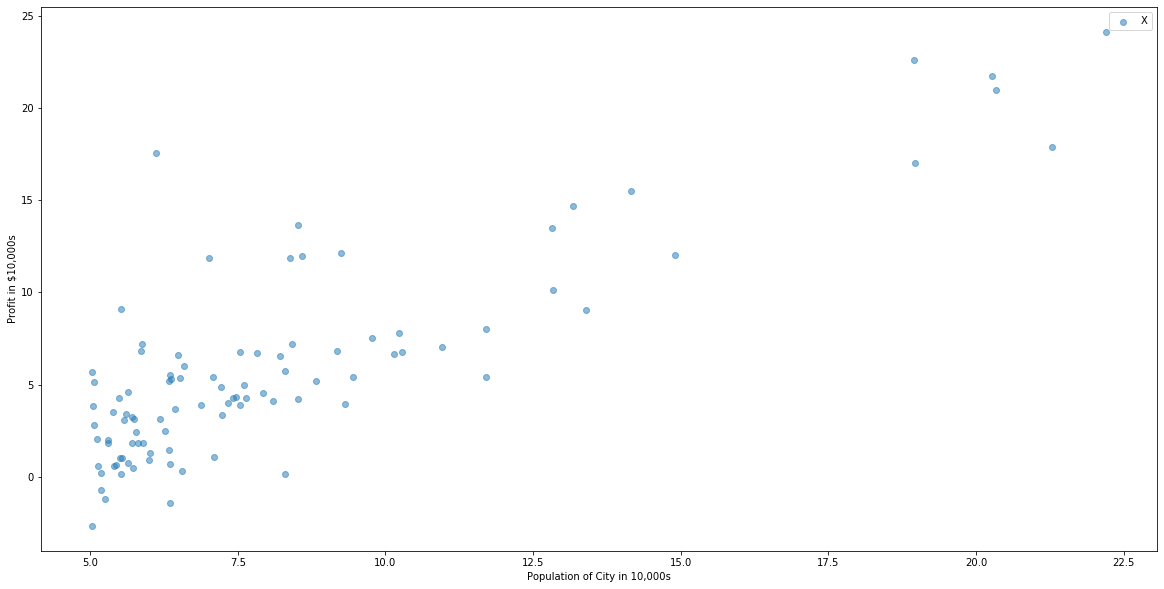

In [5]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.scatter(d1_X, d1_y, color='C0', alpha=0.5)
ax.set(xlabel='Population of City in 10,000s', ylabel='Profit in $10,000s')
ax.legend(['X'])
plt.show()

---

The straight line formula is as follows, where the parameter $\theta_0$ is the intercept of the line on the dependent variable axis, and where $\theta_1$ is the gradient of the line. Note that we use $h$ to describe the output dependent variable in order to distinguish this predicted "_hypothesis_" value from the actual known data value $y$:

$h = \theta_0 + \theta_1x_1$

We can modify this with a dummy feature $x_0 = 1$ and vectorise by:

$h = \theta_0x_0 + \theta_1x_1$<br>
$h = [\theta_0, \theta_1] \cdot [x_0, x_1]$<br>
$h = \overrightarrow{\theta} \cdot \overrightarrow{x}$<br>
$h = \overrightarrow{x} \cdot \overrightarrow{\theta}$

Let's make a function to include an offset term via the dummy feature $x_0 = 1$:

In [181]:
def add_ones(X):
    return(np.append(np.ones([X.shape[0],1]), X, axis=1))

In [182]:
d1_X_ones = add_ones(d1_X)
d1_X_ones.shape

(97, 2)

Even though the given data are 1D, this has now become a 2D problem, as we will observe the parameter space defined by the range of both $\theta_0$ and $\theta_1$ in order to find the optimum point in that space to provide the best-fit line.

---

Now the data are loaded and prepared, we define the cost function for which we seek the smallest value, as will be given by the optimum $\overrightarrow{\theta}$, which also returns the derivative of change in cost per change in $\overrightarrow{\theta}$ (one derivative value for each of its components) at a given point in parameter space i.e. at a given $\overrightarrow{\theta}$. Note that in the following code, ``theta`` is the parameter array with the features in rows, ``X`` is the independent variable array with the examples in rows and the features in columns, and ``y`` is the known dependent variable array with the examples in rows. The arguments are given to the function in this order to maintain consistency with later parts of the course, where the parameter array must come first for use with automated optimiser functions.

Also note exactly what the derivative calculation is doing - it is taking averaged weighted sums of the independent feature values, with the weighting being given by the deviations between the hypothesis dependent values and the known dependent values. Everything is taken care of by the dot-product, which is done in the order given so as to produce a column vector that has a one-to-one correspondance with the $\overrightarrow{\theta}$ column vector, as this is what the derivatives will modify:

In [165]:
def get_cost(
    theta,
    X,
    y,
    get_derivative=True,
):

    m = X.shape[0]
    h = np.dot(X, theta) # These are the predictions for the y values we're trying to match i.e. h is an array of the same size as y
    h_minus_y = h - y

    cost = \
          (1 / (2 * m)) \
        * np.sum(np.power(h_minus_y, 2))

    if (not get_derivative):
        return(cost)
    else:
        dcost_by_dtheta = (1 / m) * np.dot(np.transpose(X), h_minus_y)
        return(cost, dcost_by_dtheta)

In [173]:
d1_cost, d1_dcost_by_dtheta = get_cost(
    np.array([[0.0],[0.0]]),
    d1_X_ones,
    d1_y,
)
print(d1_cost)
print(d1_dcost_by_dtheta)
# 32.072733877455676
# [[ -5.83913505]
#  [-65.32884975]]

32.072733877455676
[[ -5.83913505]
 [-65.32884975]]


In [174]:
d1_cost, d1_dcost_by_dtheta = get_cost(
    np.array([[-1.0],[2.0]]),
    d1_X_ones,
    d1_y,
)
print(d1_cost)
print(d1_dcost_by_dtheta)
# 54.24245508201238
# [[ 9.48046495]
#  [89.3192359 ]]

54.24245508201238
[[ 9.48046495]
 [89.3192359 ]]


---

We now run gradient descent to find the optimum $\overrightarrow{\theta}$, or at least a better $\overrightarrow{\theta}$ than what we start with from an initial guess. This simply calls the cost function a specified number of times, each time giving the $\overrightarrow{\theta}$ presently had (the current point in parameter space), and each time modifying it according to the derivatives from the cost function i.e. by the tweaks that have been calculated as the best for reducing the cost at the current point in parameter space. We expect the cost to reduce with each iteration, and so the more iterations then the more likely we are to find the optimum $\overrightarrow{\theta}$. A further variable $\alpha$ is also introduced, as an additional handle on the amount by which the derivatives from the cost function are allowed to affect $\overrightarrow{\theta}$ each time. This is commonly referred to as the "_learning rate_". Although not necessary for this all to work and return the optimum parameters, the following function also records the cost at each iteration, so that we can see how it evolved:

In [175]:
def gradient_descent(
    theta,
    alpha,
    iters_num,
    X,
    y,
):

    cost, dcost_by_dtheta = get_cost(theta, X, y) # Get the initial cost and derivatives for the initial parameters, outside of the number of iterations to be done. The final cost in the list will then be for the final parameters found.
    costs = [cost]

    for iters_idx in range(iters_num):
        theta -= alpha * dcost_by_dtheta
        cost, dcost_by_dtheta = get_cost(theta, X, y)
        costs.append(cost)

    return(theta, costs)

In [176]:
d1_theta, d1_costs = gradient_descent(
    np.array([[0.0],[0.0]]),
    0.01,
    1500,
    d1_X_ones,
    d1_y,
)
print(d1_theta)
print(min(d1_costs))
# [[-3.63029144]
#  [ 1.16636235]]
# 4.483388256587725

[[-3.63029144]
 [ 1.16636235]]
4.483388256587725


Let's see how the cost evolved with iteration:

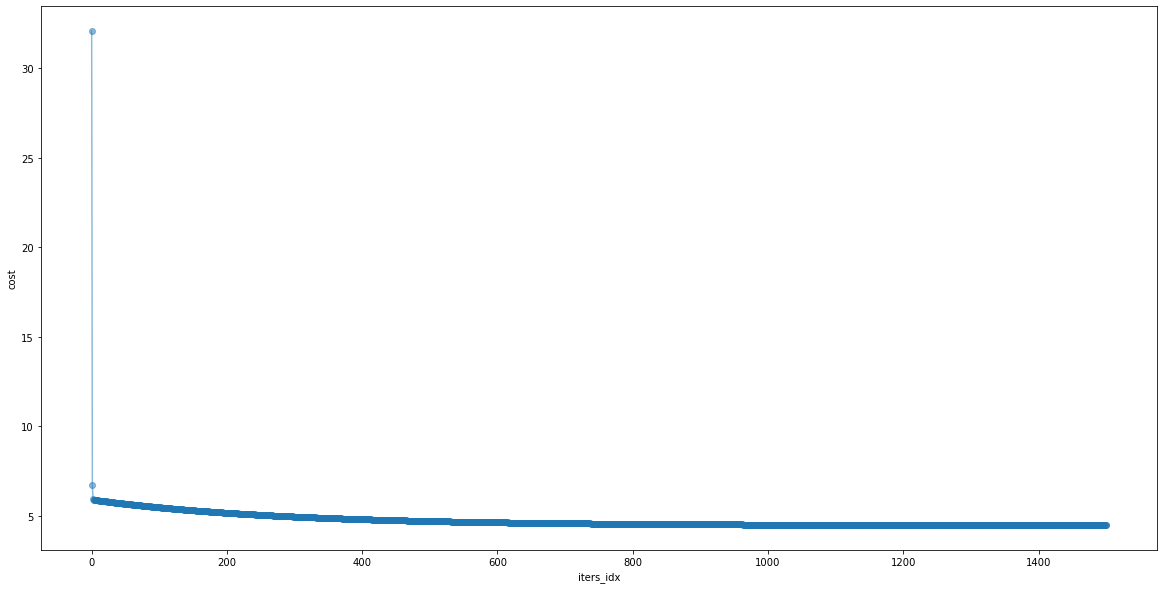

In [177]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.plot(range(len(d1_costs)), d1_costs, '-o', color='C0', alpha=0.5)
ax.set(xlabel='iters_idx', ylabel='cost')
plt.show()

Let's see the fit according to the parameters found:

In [56]:
d1_Xfit = np.transpose([np.linspace(min(d1_X[:,0]), max(d1_X[:,0]), 100)])
d1_Xfit_ones = add_ones(d1_Xfit)

d1_hfit = np.dot(d1_Xfit_ones, d1_theta)

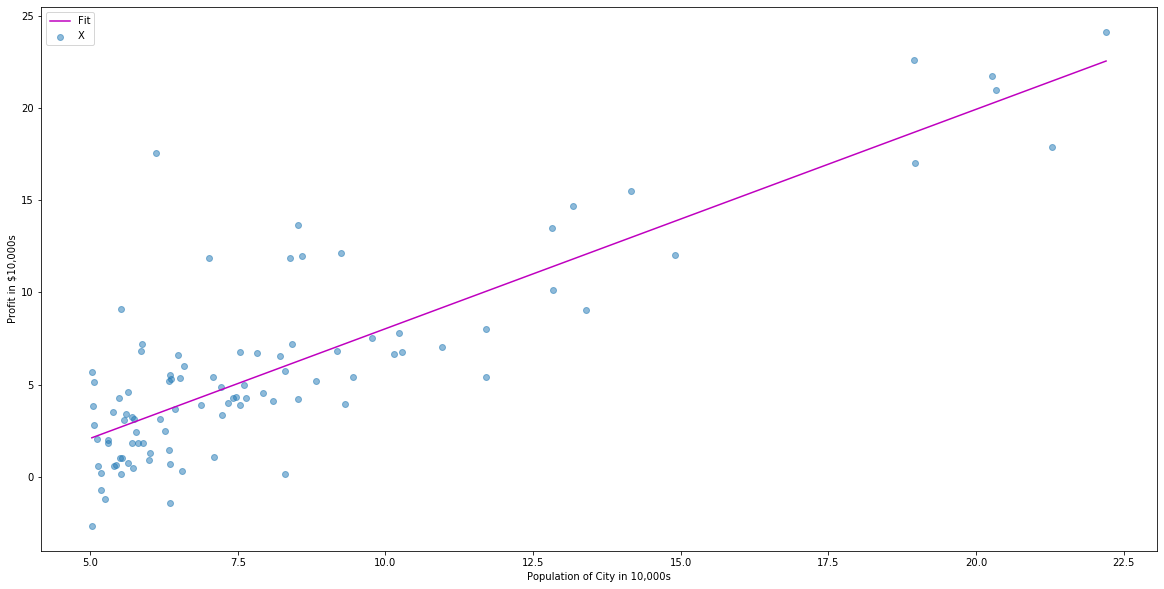

In [57]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.scatter(d1_X, d1_y, color='C0', alpha=0.5)
ax.plot(d1_Xfit_ones[:,1], d1_hfit, '-', color='m')
ax.set(xlabel='Population of City in 10,000s', ylabel='Profit in $10,000s')
ax.legend(['Fit', 'X']) # Dunno why, but the legend always puts the 'plot' style before the 'scatter' style, regardless of the above ordering
plt.show()

---

Job done. In finding the best-fit parameters, the cost function gradient caused us to take a single path through parameter space, finally reaching the minimum cost possible in the specified number of iterations. Just for illustration to get a broader view of the parameter space that was traversed, let's find the cost at multiple extra locations, not just those close to the path taken by gradient descent:

In [66]:
d1_theta0s_scan = np.linspace(-10, 10, 100)
d1_theta1s_scan = np.linspace(-1, 4, 100)
d1_theta0s_scan_meshgrid, d1_theta1s_scan_meshgrid = np.meshgrid(d1_theta0s_scan, d1_theta1s_scan)
d1_costs_scan = np.zeros([d1_theta0s_scan.shape[0], d1_theta1s_scan.shape[0]])

for d1_theta0s_scan_idx,d1_theta0_scan in enumerate(d1_theta0s_scan):
    for d1_theta1s_scan_idx,d1_theta1_scan in enumerate(d1_theta1s_scan):
        d1_costs_scan[d1_theta0s_scan_idx][d1_theta1s_scan_idx], dcost_by_dtheta = get_cost([[d1_theta0_scan],[d1_theta1_scan]], d1_X_ones, d1_y)

In [67]:
np.min(d1_costs_scan)

4.480459391893313

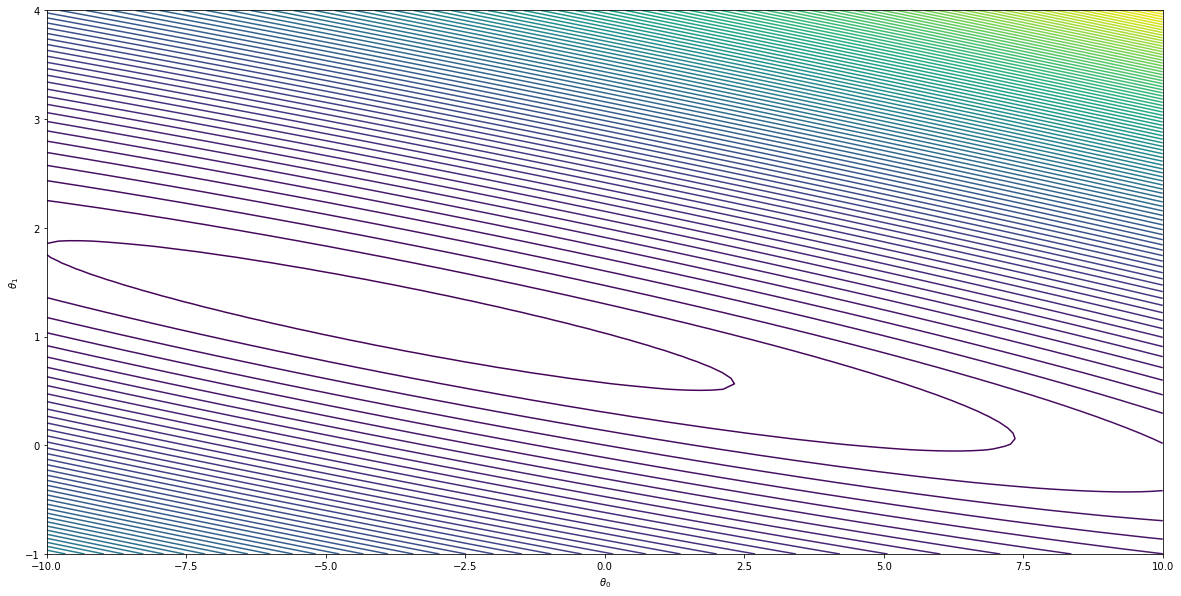

In [18]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.contour(d1_theta0s_scan, d1_theta1s_scan, np.transpose(d1_costs_scan), levels=100)
ax.set(xlabel=r'$\theta_0$', ylabel=r'$\theta_1$')
plt.show()

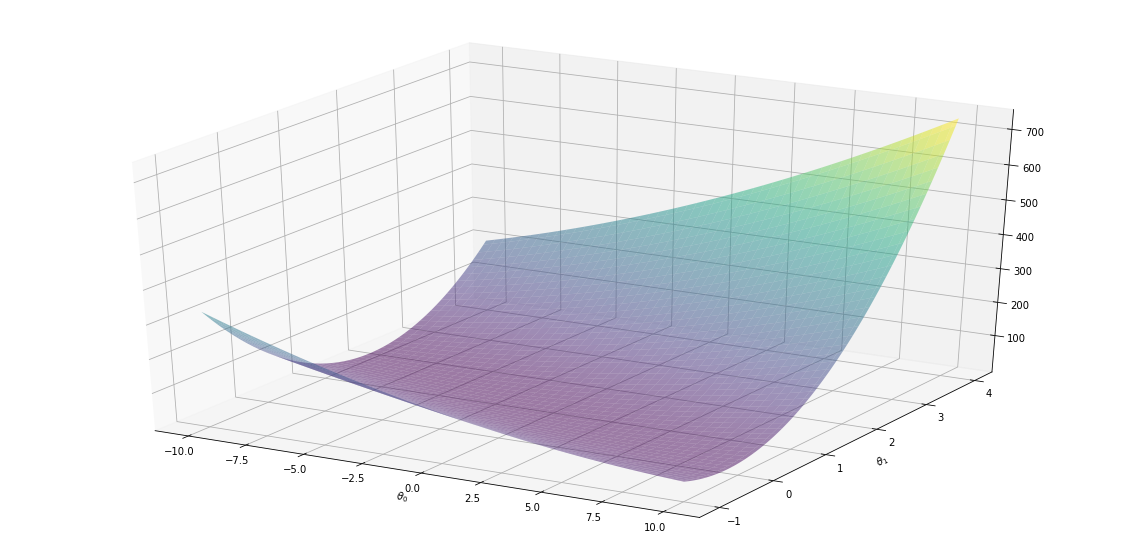

In [179]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.plot_surface(d1_theta0s_scan_meshgrid, d1_theta1s_scan_meshgrid, np.transpose(d1_costs_scan), cmap=cm.viridis, alpha=0.5)
ax.set(xlabel=r'$\theta_0$', ylabel=r'$\theta_1$')
# ax.view_init(10, 270)
plt.show()

# Exercise 1.3: Linear Regression (dimension-$d$, power-$p_d$, unregularised)
___

The above approach for finding the optimum parameters $\overrightarrow{\theta}$, that will provide the best match of hypothesis values $h$ to the given values $y$, is not simply for straight lines through 1D data, but is general. There are two paths of increasing complexity from straight-line 1D data, namely data with more complex shapes, and data with more dimensions. For the former, we require higher powers of the data dimensions in the hypothesis function, each with a corresponding component of $\overrightarrow{\theta}$. For the latter, each higher dimension also requires a corresponding set of $\overrightarrow{\theta}$ components, one for each power present.

So in the simplest case as already seen, we had the following hypothesis function with the dummy feature $x_0=1$ already introduced, in order to give an offset ($y$-axis intercept), which is also general for higher dimensional cases:

$h = \theta_0x_0 + \theta_1x_1$

Now introducing higher powers for more complex shapes than straight lines:

$h = \theta_0x_0 + (\theta_{11}x_1^1 + \theta_{12}x_1^2 + \dots + \theta_{1p_1}x_1^{p_1})$

And introducing higher dimensions with their own higher powers:

$h = \theta_0x_0 + (\theta_{11}x_1^1 + \theta_{12}x_1^2 + \dots + \theta_{1p_1}x_1^{p_1}) + (\theta_{21}x_2^1 + \theta_{22}x_2^2 + \dots + \theta_{2p_2}x_2^{p_2}) + \dots + (\theta_{d1}x_d^1 + \theta_{d2}x_d^2 + \dots + \theta_{dp_d}x_d^{p_d})$

The first subscript in the above is for the dimension, and the second subscript is for the power. Note that each dimension can have a different highest power $p_d$. The most important thing to note is that these more complex expressions are still _linear sums_ (and hence this is still _linear_ regression), and so can be manipulated into a dot-product between a data vector $\overrightarrow{x}$ and a parameter vector $\overrightarrow{\theta}$:

$h = [\theta_0, \theta_{11}, \theta_{12}, \dots, \theta_{1p_1}, \theta_{21}, \theta_{22}, \dots, \theta_{2p_2}, \dots, \theta_{d1}, \theta_{d2}, \dots, \theta_{dp_d}] \cdot [x_0, x_1^1, x_1^2, \dots, x_1^{p_1}, x_2^1, x_2^2, \dots, x_2^{p_2}, \dots, x_d^1, x_d^2, \dots, x_d^{p_d}]$<br>
$h = \overrightarrow{\theta} \cdot \overrightarrow{x}$<br>
$h = \overrightarrow{x} \cdot \overrightarrow{\theta}$

The method used for calculating the cost of a given state of the parameter vector, and the change by which that cost can best be reduced at that point in parameter space, is unchanged from that seen previously. The same iterative gradient descent method can then be used to call the cost function multiple times, and thereby seek the optimum $\overrightarrow{\theta}$, or, rather, the best $\overrightarrow{\theta}$ that can be found after a set number of iterations. We could also change the termination condition to not be dictated by a set number of iterations, but by some acceptable minimum cost or change in cost per iteration. Various tweaks to the method can be made, but the main story remains the same.

To illustrate with a slightly more complex example than the 1D case seen previously, we now fit a plane to a 2D data set, using the functions as already defined. We are therefore just increasing the dimensionality of the data, not the complexity of its shape i.e. we still only go to the first power in each dimension. There is, however, one additional step we take in the following that was not done in the 1D case. Rather than using the dimension positions of the data points as given, we instead normalise each set of dimension positions independently, by deducting the mean and dividing by the standard deviation of each set of dimension positions. This modified data set is then somewhat homogenised in all dimensions, which in general is more suitable for many machine learning techniques. This normalisation is pretty standard, and we will use it often from now on. Other than that, the steps are the same as before. First let's just load the data and check it out:

In [20]:
d2 = np.loadtxt('ex1/ex1data2.txt', delimiter=',')
d2.shape

(47, 3)

In [21]:
d2_X = d2[:,0:2]
d2_X.shape

(47, 2)

In [22]:
d2_y = np.transpose([d2[:,2]])
d2_y.shape

(47, 1)

In [185]:
del(d2)

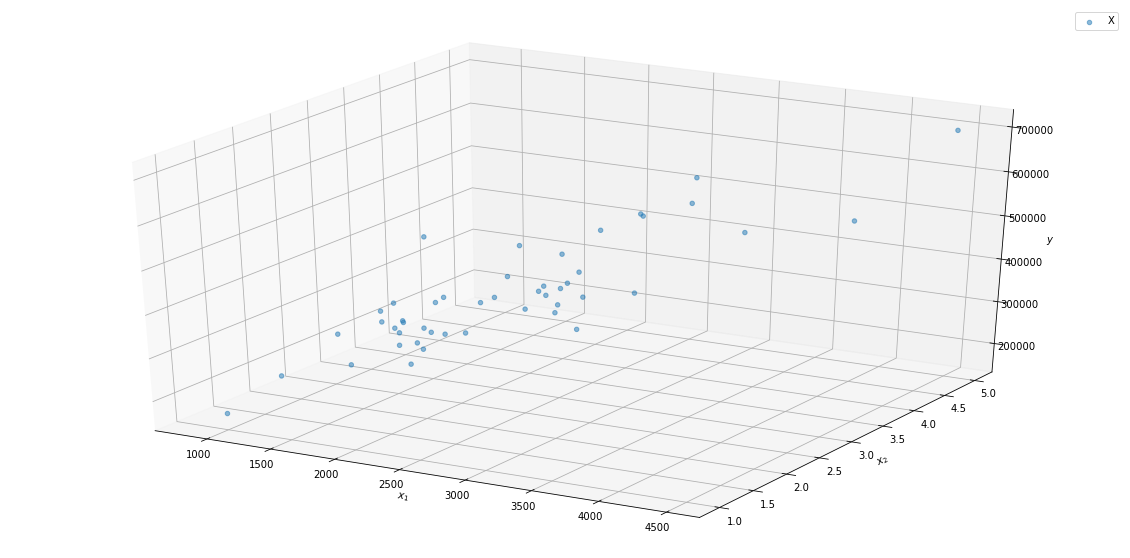

In [23]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.scatter(d2_X[:,0], d2_X[:,1], d2_y, color='C0', alpha=0.5)
ax.set(xlabel=r'$x_1$', ylabel=r'$x_2$', zlabel=r'$y$')
ax.legend(['X'])
plt.show()

---

Now normalise and add the ones:

In [24]:
d2_X_mu = np.mean(d2_X, axis=0)
d2_X_sigma = np.std(d2_X, axis=0)
d2_X_norm = (d2_X - d2_X_mu) / d2_X_sigma
d2_X_norm.shape

(47, 2)

In [183]:
d2_X_norm_ones = add_ones(d2_X_norm)
d2_X_norm_ones.shape

(47, 3)

---

Now initialise the settings and run gradient descent on the cost function:

In [178]:
d2_theta, d2_costs = gradient_descent(
    np.array([[0.0],[0.0],[0.0]]),
    0.01,
    1500,
    d2_X_norm_ones,
    d2_y,
)
print(d2_theta)
print(min(d2_costs))
# [[340412.56301439]
#  [109370.05670466]
#  [ -6500.61509507]]
# 2043282709.9327548

[[340412.56301439]
 [109370.05670466]
 [ -6500.61509507]]
2043282709.9327548


Let's see how the cost evolved with iteration:

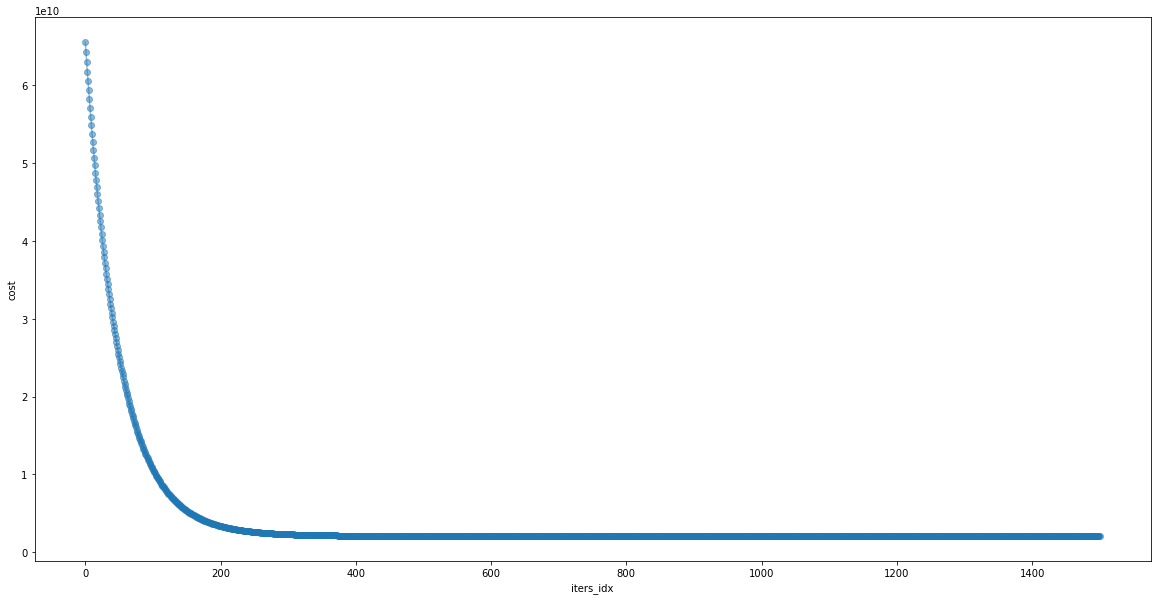

In [170]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.plot(range(len(d2_costs)), d2_costs, '-o', color='C0', alpha=0.5)
ax.set(xlabel='iters_idx', ylabel='cost')
plt.show()

Let's see the fit according to the parameters found:

In [29]:
d2_X1_range = max(d2_X[:,0]) - min(d2_X[:,0])
d2_Xfit1_lower = min(d2_X[:,0]) - (d2_X1_range * 0.2)
d2_Xfit1_upper = max(d2_X[:,0]) + (d2_X1_range * 0.2)

d2_X2_range = max(d2_X[:,1]) - min(d2_X[:,1])
d2_Xfit2_lower = min(d2_X[:,1]) - (d2_X2_range * 0.2)
d2_Xfit2_upper = max(d2_X[:,1]) + (d2_X2_range * 0.2)

d2_Xfit1 = np.linspace(d2_Xfit1_lower, d2_Xfit1_upper, 100)
d2_Xfit2 = np.linspace(d2_Xfit2_lower, d2_Xfit2_upper, 100)

# Note that the meshgrids, and everything that follows from them, are in [x2,x1] order, not [x1,x2]. Dunno why that is, counterintuitive.

d2_Xfit1_meshgrid, d2_Xfit2_meshgrid = np.meshgrid(d2_Xfit1, d2_Xfit2)
d2_Xfit1_meshgrid_flat = np.reshape(d2_Xfit1_meshgrid, np.product(d2_Xfit1_meshgrid.shape))
d2_Xfit2_meshgrid_flat = np.reshape(d2_Xfit2_meshgrid, np.product(d2_Xfit2_meshgrid.shape))

d2_Xfit = np.transpose([d2_Xfit1_meshgrid_flat, d2_Xfit2_meshgrid_flat])
d2_Xfit_norm = (d2_Xfit - d2_X_mu) / d2_X_sigma
d2_Xfit_norm_ones = add_ones(d2_Xfit_norm)

d2_hfit = np.dot(d2_Xfit_norm_ones, d2_theta)
d2_hfit_meshgrid = np.reshape(d2_hfit, [d2_Xfit2.shape[0], d2_Xfit1.shape[0]])

# Note that we can achieve the same result as everything that follows the above meshgrid
# declarations by the following. However, even though this looks more compact, the trade-off is
# that it uses loops, which in general we try and avoid in order to use the full linear algebra
# abilities of numpy, which should be more efficient:

# d2_hfit_meshgrid = np.zeros([d2_Xfit2.shape[0], d2_Xfit1.shape[0]])

# for d2_Xfit1_idx,d2_Xfit1_val in enumerate(d2_Xfit1):
#     for d2_Xfit2_idx,d2_Xfit2_val in enumerate(d2_Xfit2):
#         d2_hfit_meshgrid[d2_Xfit2_idx][d2_Xfit1_idx] = np.dot([1, (d2_Xfit1_val-d2_mu[0])/d2_sigma[0], (d2_Xfit2_val-d2_mu[1])/d2_sigma[1]], d2_theta)

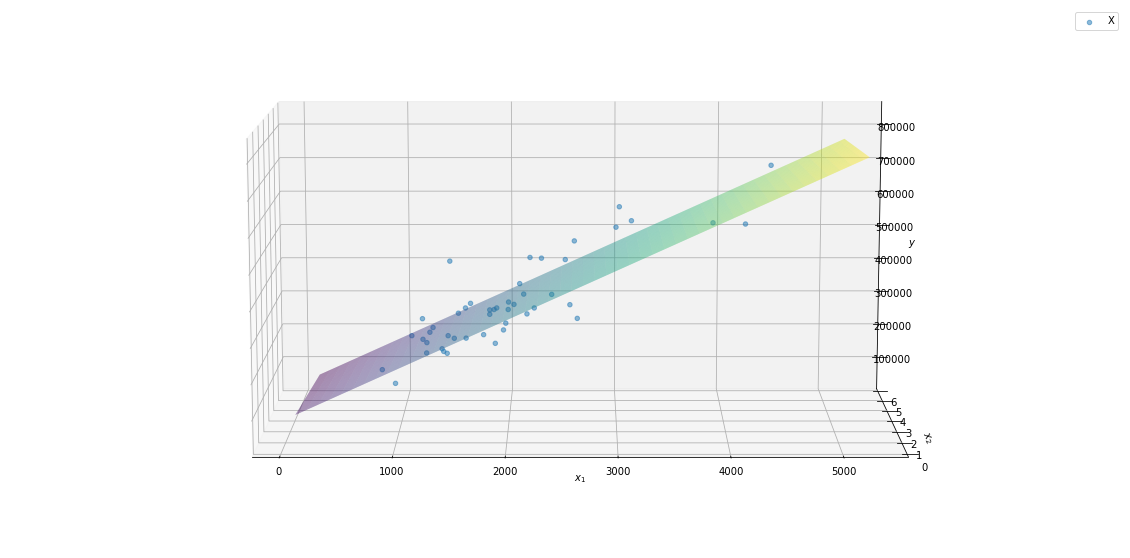

In [180]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.scatter(d2_X[:,0], d2_X[:,1], d2_y, color='C0', alpha=0.5)
ax.plot_surface(d2_Xfit1_meshgrid, d2_Xfit2_meshgrid, d2_hfit_meshgrid, cmap=cm.viridis, alpha=0.5)
ax.set(xlabel=r'$x_1$', ylabel=r'$x_2$', zlabel=r'$y$')
ax.legend(['X'])
ax.view_init(10, 270)
plt.show()

---

In order to make a prediction from the trained optimum $\overrightarrow{\theta}$ for some point in data space (a given $\overrightarrow{x}$), we must first run it through the same steps used to convert the training data, and then take the dot-product with the trained optimum $\overrightarrow{\theta}$ to give the prediction. We saw this above in bulk with the production of the best-fit plane values, but here we show a reduced example with just a couple of points in data space that we're interested in:

In [34]:
d2_Xtest = np.array([[1650,3], [1800,4]])
d2_Xtest_norm = (d2_Xtest - d2_X_mu) / d2_X_sigma
d2_Xtest_norm_ones = add_ones(d2_Xtest_norm)
d2_htest = np.dot(d2_Xtest_norm_ones, d2_theta)
print(d2_htest)

[[293098.46667577]
 [305330.47826461]]


---

Other than gradient descent (a numerical method), for this case of determining the optimum $\overrightarrow{\theta}$ we can instead do a compact matrix multiplication (an analytical method). If $X$ has data point examples as rows and features as columns, then $X^T$ has features as rows and data point examples as columns. We then have that $X^T \cdot X$ has the examples dimension contracted out, and we are given a square matrix with side length equal to the number of features. Furthermore, this will be symmetrical about the leading diagonal. Likewise, if the column vector $y$ has example data points as rows, then $X^T \cdot y$ has the examples dimension contracted out, giving a column vector of length equal to the number of features. Finally, $(X^T \cdot X)^{-1} \cdot (X^T \cdot y)$ is a square matrix multiplying a column vector, giving a column vector of the same size i.e. the number of features. This, it turns out, is the optimum $\overrightarrow{\theta}$ to minimise the mean-squares cost function:

In [171]:
def get_theta_analytical(
    X,
    y,
):

    Xtrans_dot_X_inv = np.linalg.inv(np.dot(np.transpose(X), X))
    Xtrans_dot_y = np.dot(np.transpose(X), y)
    theta = np.dot(Xtrans_dot_X_inv, Xtrans_dot_y)

    return(theta)

In [172]:
d2_theta_numerical = d2_theta
d2_theta_analytical = get_theta_analytical(d2_X_norm_ones, d2_y)
print(d2_theta_numerical)
print(d2_theta_analytical)

[[340412.56301439]
 [109370.05670466]
 [ -6500.61509507]]
[[340412.65957447]
 [109447.79646964]
 [ -6578.35485416]]
